# MLP

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import pandas as pd
import numpy as np
import ast
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras import regularizers
from sklearn.model_selection import KFold
from tensorflow.keras import backend as K

In [5]:
data = pd.read_csv("./embeddings_data.csv")

In [6]:
X = np.vstack([np.array(ast.literal_eval(vec), dtype=float) for vec in data["embedding_cls"]])
y = data["class"].values

In [7]:
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=31, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.2, random_state=31, stratify=y_temp)

In [8]:
def build_model(n_hidden_layers=1, n_neurons=128, input_dim=None):
    model = Sequential()
    model.add(Input(shape=(input_dim,)))
    current_neurons = n_neurons
    for _ in range(n_hidden_layers):
        model.add(Dense(current_neurons, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
        model.add(Dropout(0.3))
        current_neurons = max(8, current_neurons // 2)
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [18]:
param_grid = {
    "n_hidden_layers": [1, 2, 3],
    "n_neurons": [32, 64, 128]
}

kfold = KFold(n_splits=3, shuffle=True, random_state=42)

best_params = None
best_score = 0
best_model = None
best_history = None

# Grid search manual 
for layers in param_grid["n_hidden_layers"]:
    for neurons in param_grid["n_neurons"]:
        fold_scores = []
        print(f"\n Evaluando: capas={layers}, neuronas={neurons}")
        
        for train_idx, val_idx in kfold.split(X):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]

            K.clear_session()
            model = build_model(n_hidden_layers=layers, n_neurons=neurons, input_dim=X.shape[1])
            history = model.fit(X_train, y_train,
                                validation_data=(X_val, y_val),
                                epochs=20,
                                batch_size=32,
                                verbose=0)
            
            acc = history.history["val_accuracy"][-1]
            fold_scores.append(acc)
        
        mean_acc = np.mean(fold_scores)
        print(f"Promedio val_accuracy: {mean_acc:.4f}")
        
        if mean_acc > best_score:
            best_score = mean_acc
            best_params = (layers, neurons)

print(f"\n Mejor combinación: capas={best_params[0]}, neuronas={best_params[1]}")




 Evaluando: capas=1, neuronas=32
Promedio val_accuracy: 0.8565

 Evaluando: capas=1, neuronas=64
Promedio val_accuracy: 0.8567

 Evaluando: capas=1, neuronas=128
Promedio val_accuracy: 0.8545

 Evaluando: capas=2, neuronas=32
Promedio val_accuracy: 0.8541

 Evaluando: capas=2, neuronas=64
Promedio val_accuracy: 0.8579

 Evaluando: capas=2, neuronas=128
Promedio val_accuracy: 0.8570

 Evaluando: capas=3, neuronas=32
Promedio val_accuracy: 0.8578

 Evaluando: capas=3, neuronas=64
Promedio val_accuracy: 0.8573

 Evaluando: capas=3, neuronas=128
Promedio val_accuracy: 0.8570

 Mejor combinación: capas=2, neuronas=64


In [19]:
model = build_model(n_hidden_layers=best_params[0], n_neurons=best_params[1], input_dim=X.shape[1])
best_history = model.fit(X_train[:10000], y_train[:10000], validation_split=0.2, epochs=30, batch_size=32, verbose=0)
best_model = model





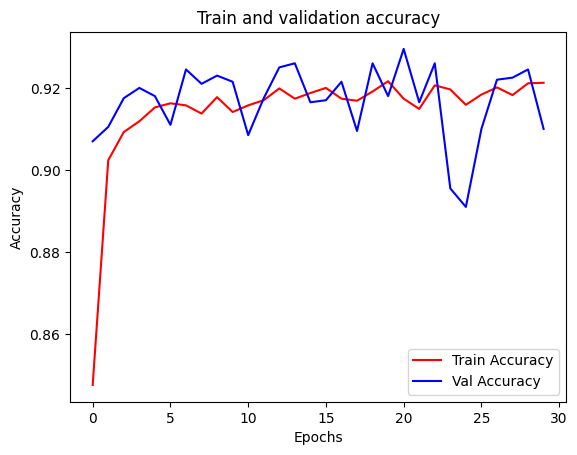

In [20]:
plt.plot(best_history.history['accuracy'], label='Train Accuracy', color='red')
plt.plot(best_history.history['val_accuracy'], label='Val Accuracy', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Train and validation accuracy')
plt.show()

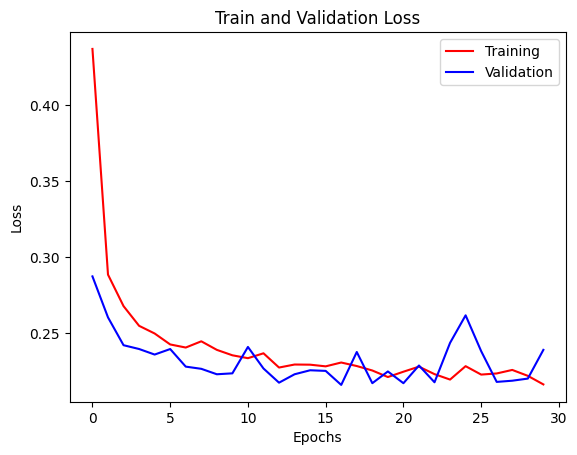

In [21]:
plt.plot(best_history.history['loss'], label='Training', color='red')
plt.plot(best_history.history['val_loss'], label='Validation', color='blue')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()
plt.show()

299/299 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
              precision    recall  f1-score   support

           0       0.81      0.86      0.84      4669
           1       0.86      0.81      0.83      4869

    accuracy                           0.83      9538
   macro avg       0.84      0.84      0.83      9538
weighted avg       0.84      0.83      0.83      9538



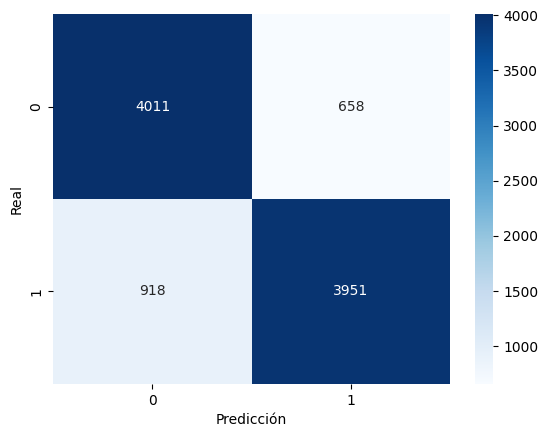

In [22]:
y_pred = best_model.predict(X_test)
y_pred = (y_pred > 0.5).astype(int)

print(classification_report(y_test, y_pred))

conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, xticklabels = ["0", "1"], yticklabels = ["0", "1"], annot=True, cmap='Blues', fmt = 'g')
plt.ylabel("Real")
plt.xlabel("Predicción")
plt.show()